In [358]:
#Import pandas, matplotlib.pyplot, and seaborn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import datetime
import os
from tqdm import tqdm
%matplotlib inline
import numpy as np
import re
import plotly
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

In [359]:
myfold = os.getcwd()

In [360]:
retail_df = pd.read_csv(myfold + '/online_retail_cleaned.csv',index_col=[0])

In [361]:
retail_df.InvoiceDate = pd.to_datetime(retail_df.InvoiceDate)
retail_df.CustomerID = retail_df.CustomerID.astype('int64')
retail_df['InvoiceYearMonth'] = retail_df['InvoiceDate'].map(lambda date: 100*date.year + date.month)


In [362]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,InvoiceYearMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,201012
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,201012
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,201012
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,201012
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,201012


### What is the total revenue and total active customers by month?

In [348]:
fig = make_subplots(rows=1, cols=2)
retail_rev = retail_df.groupby(retail_df.InvoiceYearMonth).Amount.sum().reset_index()
fig.add_trace( go.Scatter(x=retail_rev.InvoiceYearMonth, y = retail_rev.Amount),row=1,col=1)

fig.data[0].name = "Revenue"

monthly_active_cust = retail_df.groupby(retail_df.InvoiceYearMonth).CustomerID.nunique().reset_index()
fig.add_trace(go.Scatter(x=monthly_active_cust.InvoiceYearMonth, y=monthly_active_cust.CustomerID),
    row=1, col=2)

fig.data[1].name = "Number of Active Customers"
fig.update_xaxes(type='category')
fig.update_layout(height=400, width=1000, title_text="Revenue & Active Customers by Month")
fig.show()

Our revenue is growing especially Aug ‘11 onwards. The data for December does not apper to be incomplete. We can see In April, Monthly Active Customer number dropped  from 974 to 856. 

### What is the monthly order Count & Average Revenue per Order?

In [349]:
fig = make_subplots(rows=1, cols=2)
Av_monthly_sales = retail_df.groupby(retail_df.InvoiceYearMonth).Quantity.sum().reset_index()
fig.add_trace( go.Scatter(x=Av_monthly_sales.InvoiceYearMonth, y = Av_monthly_sales.Quantity),row=1,col=1)

fig.data[0].name = "Orders per Month"

rev_per_order = retail_df.groupby(retail_df.InvoiceYearMonth).Amount.mean().reset_index()
fig.add_trace(go.Bar(x=rev_per_order.InvoiceYearMonth, y=rev_per_order.Amount),
    row=1, col=2)

fig.data[1].name = "Average Revenue per Order"
fig.update_xaxes(type='category')
fig.update_layout(height=400, width=1000, title_text="Number of Orders by Month & Average Revenue per Order")
fig.show()

As expected order count also declained in April. Also, Average revenue per order droped in April.

### Which Country accounts for Maximum sales?

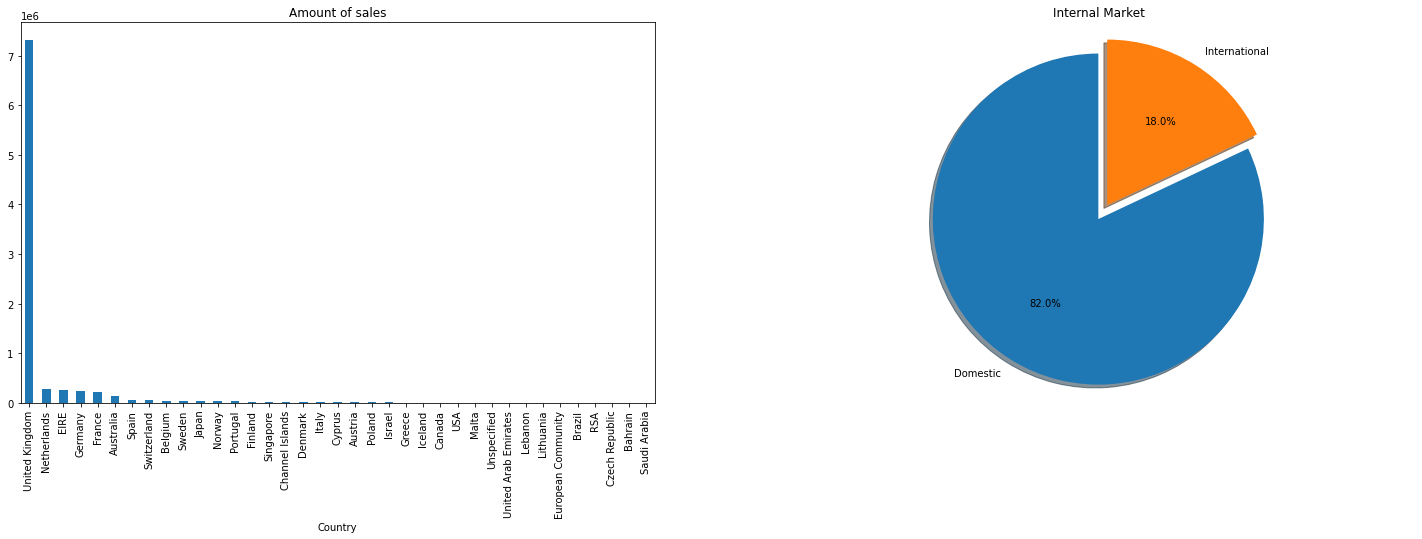

In [350]:
# Amount of sales by country
fig = plt.figure(figsize=(25, 7))
f1 = fig.add_subplot(121)
sales = retail_df.groupby(['Country']).Amount.sum().sort_values(ascending=False)\
                                   .plot(kind='bar',title= 'Amount of sales')

# Domestic and International sales
retail_df['Internal'] = retail_df.Country.apply(lambda x: 'Yes' if x == 'United Kingdom' else 'No')
market = retail_df.groupby(["Internal"]).Amount.sum().sort_values(ascending = False)
labels = 'Domestic', 'International'
explode = (0, 0.1) 
f2 = fig.add_subplot(122)
plt.pie(market, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.axis('equal')  
plt.title('Internal Market')
plt.show()

It is clear that majority of our sales are to domestic customers in United Kingdom.

### What is the Revenue per Month for New and Existing Customers?

A new customer will be determined by their first purchase in our defined monthly time period.

In [351]:
#create a dataframe contaning CustomerID and first purchase date

min_purch_date = retail_df.groupby(['CustomerID']).InvoiceDate.min().reset_index()
min_purch_date.columns = ['CustomerID','MinPurchaseDate']
min_purch_date['MinPurchaseYearMonth']= min_purch_date.MinPurchaseDate.apply(lambda date: 100*date.year + date.month)

#merge first purchase date column to our main dataframe
retail_df = pd.merge(retail_df,min_purch_date, on= 'CustomerID')

# add a new column UserType and categorize the customer purchase 
retail_df['UserType'] = 'New'
retail_df.loc[retail_df.InvoiceYearMonth > retail_df.MinPurchaseYearMonth,'UserType'] = 'Existing'   
    
#calculate the Revenue per month for each user type
revenue_per_user = retail_df.groupby(['InvoiceYearMonth','UserType']).Amount.sum().reset_index()

revenue_per_user= revenue_per_user.query("InvoiceYearMonth != 201012 and InvoiceYearMonth != 201112")

In [352]:
x_existing = revenue_per_user[revenue_per_user['UserType'] == 'Existing'].InvoiceYearMonth.sort_values(ascending=False)
y_existing = revenue_per_user[revenue_per_user['UserType'] == 'Existing'].Amount
x_new = revenue_per_user.query("UserType == 'New'")['InvoiceYearMonth'].sort_values(ascending=False)
y_new = revenue_per_user.query("UserType == 'New'")['Amount']

fig = go.Figure()

fig.add_trace(go.Scatter(x=x_existing, y=y_existing,mode='lines',name='Existing'))
fig.update_xaxes(type='category')
fig.add_trace(go.Scatter(x=x_new, y=y_new,mode='lines+markers',name='New'))

fig.update_xaxes(type='category')

fig.show()

Existing customers are showing a positive trend. Our customer base is growing but new customers have a slight negative trend.

### What is the contribution of our top 10 customers to revenue and total orders?

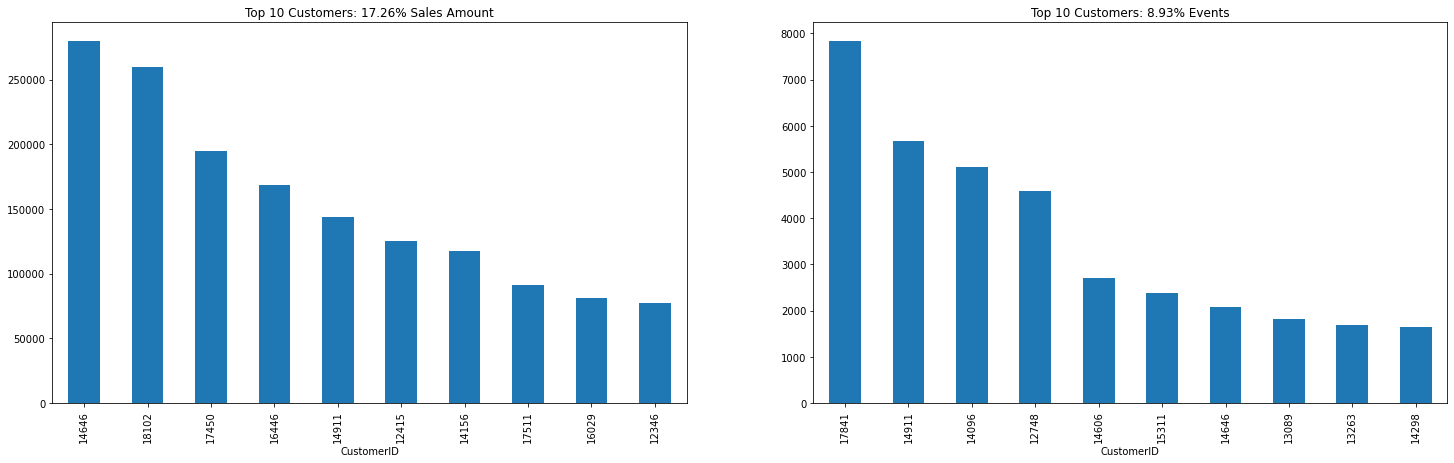

In [353]:
# Percentage sales of top 10 customers
fig = plt.figure(figsize=(25, 7))
f1 = fig.add_subplot(121)
top_10_sales =  retail_df.groupby(["CustomerID"]).Amount.sum().sort_values(ascending = False)[:10].sum()                          
total_sales = retail_df.groupby(["CustomerID"]).Amount.sum().sort_values(ascending = False).sum()
percent_sales = np.round((top_10_sales/total_sales) * 100,2)
g=retail_df.groupby(["CustomerID"]).Amount.sum().sort_values(ascending = False)[:10].plot(kind='bar', title='Top 10 Customers: {:3.2f}% Sales Amount'.format(percent_sales))

# Percentage events of top 10 customers
f2 = fig.add_subplot(122)
orders_top10 =  retail_df.groupby(["CustomerID"]).Amount.count().sort_values(ascending = False)[:10].sum()
total_orders =  retail_df.groupby(["CustomerID"]).Amount.count().sort_values(ascending = False).sum()
percent_orders = np.round((orders_top10/total_orders)*100,2)
g=retail_df.groupby(["CustomerID"]).Amount.count().sort_values(ascending = False)[:10].plot(kind='bar', title='Top 10 Customers: {:3.2f}% Events'.format(percent_orders)) 


It is seen that the top 10 customers contribute approximately to 18% of revenue and 9.0% of orders .

### What are our top 10 products and what is their contribution to revenue and total orders?

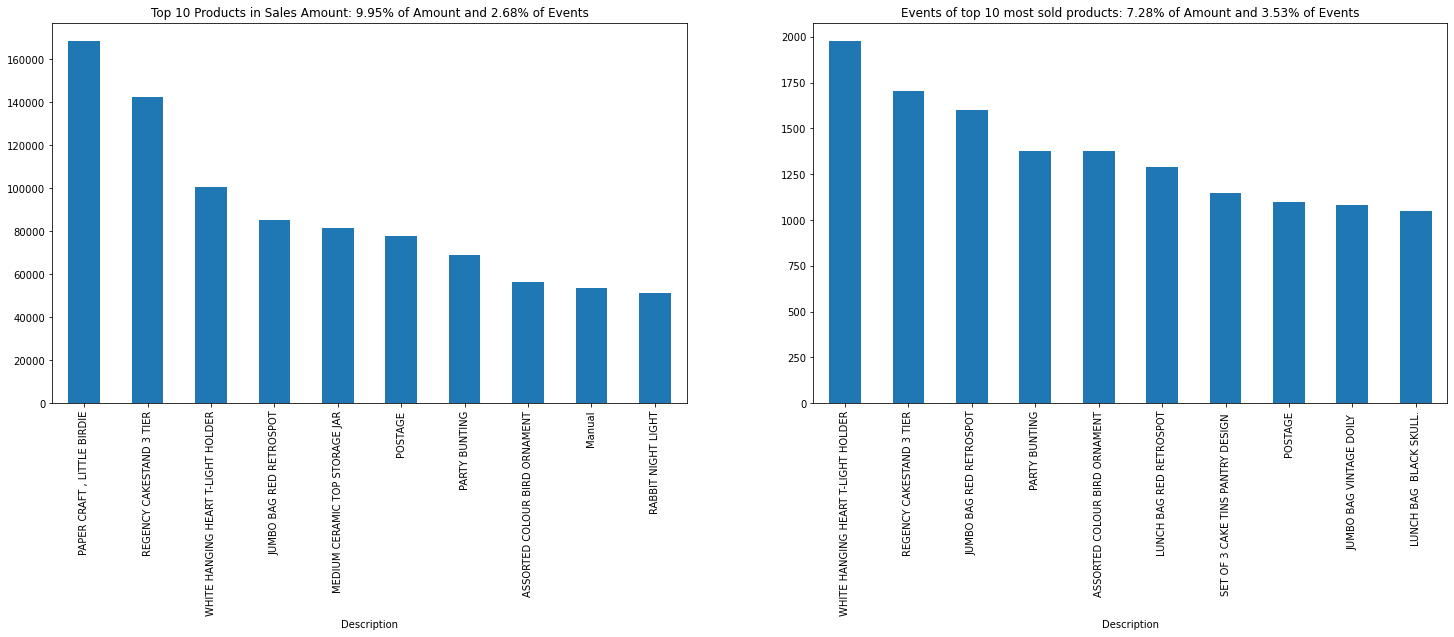

In [354]:
revenue = retail_df.groupby(["Description"]).Amount.sum().sort_values(ascending=False)
inv = retail_df[["Description", "InvoiceNo"]].groupby(["Description"]).InvoiceNo.unique().agg(np.size).sort_values(ascending = False)
fig = plt.figure(figsize=(25, 7))
f1 = fig.add_subplot(121)
Top10 = list(revenue[:10].index)
percent_sales =  np.round((revenue[Top10].sum()/revenue.sum()) * 100, 2)
percent_orders = np.round((inv[Top10].sum()/inv.sum()) * 100, 2)
g = Amountsum[Top10].plot(kind='bar', title='Top 10 Products in Sales Amount: {:3.2f}% of Amount and {:3.2f}% of Events'.\
                       format(percent_sales, percent_orders))



f1 = fig.add_subplot(122)
Top10Ev = list(inv[:10].index)
percent_sales =  np.round((revenue[Top10Ev].sum()/revenue.sum()) * 100, 2)
percent_events = np.round((inv[Top10Ev].sum()/inv.sum()) * 100, 2)
g = inv[Top10Ev].\
    plot(kind='bar', title='Events of top 10 most sold products: {:3.2f}% of Amount and {:3.2f}% of Events'.\
                       format(percent_sales, percent_events))




Our top 10 product by revenue contributes to 9.95% total revenue and 2.68% of the orders.
Top 10 most sold products contribute to 7.28% of revenue and 3.53% of orders.

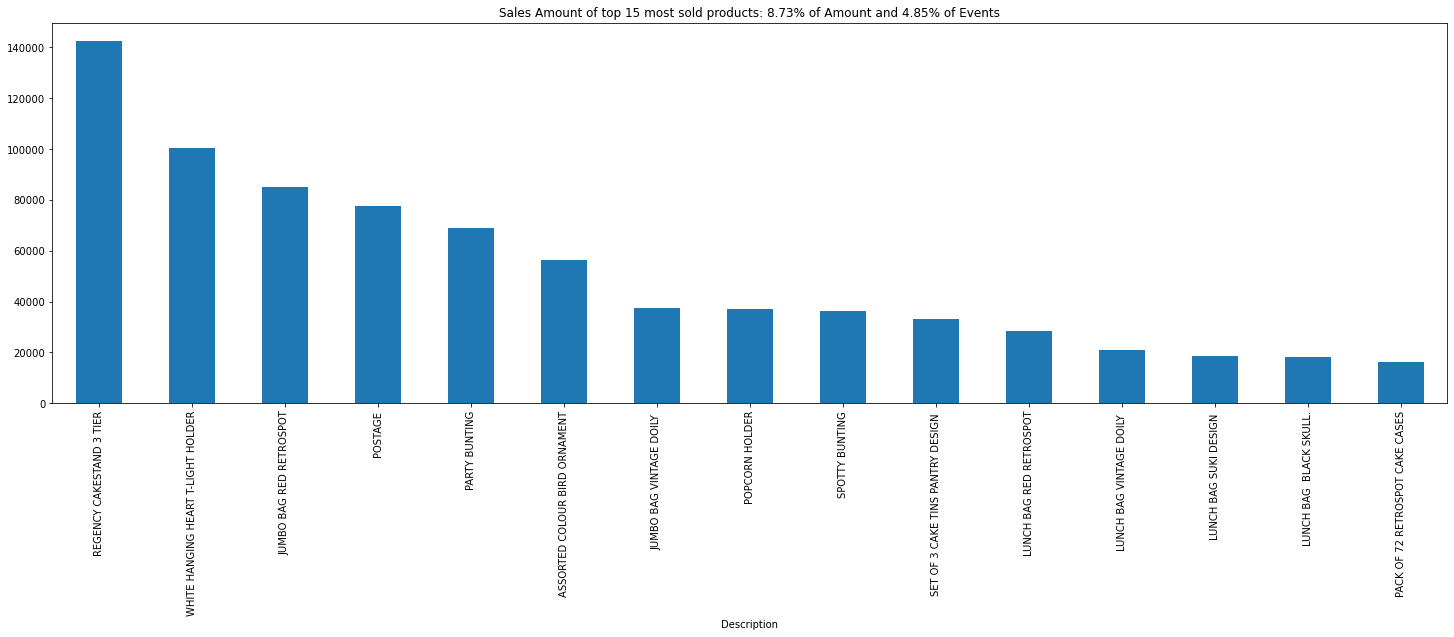

In [355]:
fig = plt.figure(figsize=(25, 7))
Top15ev = list(inv[:15].index)
percent_sales =  np.round((revenue[Top15ev].sum()/revenue.sum()) * 100, 2)
percent_events = np.round((inv[Top15ev].sum()/inv.sum()) * 100, 2)
g = revenue[Top15ev].sort_values(ascending = False).plot(kind='bar', 
         title='Sales Amount of top 15 most sold products: {:3.2f}% of Amount and {:3.2f}% of Events'.\
         format(percent_sales, percent_events))

Top 15 most sold products contribute to 8.73% of revenue and 4.85% of orders.

### Save the intermediate data

In [363]:
retail_df.to_csv('online_retail_eda.csv')